# Práctica 2. Ejercicio Sparklyr con Vuelos (EDA + ML)

**Nota: en negrita las aclaraciones sobre los enunciados**

Fecha de entrega jueves 21/12/2023 EOD (End-Of-Day).

Renombrad vuestro notebook como TXD-2023-P2-*Apellido*-*Nombre*. Compartidlo con el usuario **diegoteijeiro**. 

NOTA: La versión que compartáis, aseguraos que esté guardada con *Commit, Save & Run All*.

La lista de ejercicios propuestos, cada uno con un peso del 50% en la nota de la práctica, es:

1. Analiza distintos modelos predictivos de la variable GAIN utilizando el método de regresión linear y justifica cuál es el mejor que encuentras. Se espera que introduzcáis características para ver si ajustan mejor los datos, por ejemplo la hora o el día de la semana. Algunas pruebas se pueden documentar en texto, explicando lo que se hace y otras podéis presentarla con una gráfica. También, se pide explorar algún modelo alternativo como Random Forest.

2. Analiza distintos modelos usando Naive Bayes que nos permitan predecir la probabilidad de que un vuelo llegue con más de 15 minutos de retraso, y justifica cuál sería el mejor. Analiza qué probabilidad existe de retraso en función de ciertos parámetros, mes, día de la semana, franja temporal de día, etc... Adicionalmente comparar brevemente con un modelo basado en Random Forest.

**NOTA: haced uso de los datos de 2019 y con un número representativo de los vuelos de ese año, entre el 2% y el 10%.**


In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

library(dplyr)

# No more basic plots!
# https://www.publichealth.columbia.edu/sites/default/files/media/fdawg_ggplot2.html
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "airline-delay-analysis-2019" "openflights-20200201-dump"  
[3] "spark-3-2-tar"               "usdpttransport-bts-carriers"

In [2]:
library(sparklyr)
spark_install(version = "3.2")

# Se utiliza la versión local como desarrollo, en producción utilizaría un clúster
sc <- spark_connect(master = "local")

#sc


Attaching package: ‘sparklyr’


The following object is masked from ‘package:purrr’:

    invoke


The following object is masked from ‘package:stats’:

    filter




In [3]:
library(sparklyr)
spark_install_tar("/kaggle/input/spark-3-2-tar/spark-3.2.4-bin-hadoop3.2.tgz")

# Se utiliza la versión local como desarrollo, en producción utilizaría un clúster
sc <- spark_connect(master = "local")

#sc

Re-using existing Spark connection to local



In [4]:
# Descripcion de las variables:
# Data comes from the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS).
# https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time
# 

flights <- read.csv('../input/airline-delay-analysis-2019/2019.csv')
flights %>% head(n=5)

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,⋯,ARR_TIME,ARR_DELAY,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,X
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,2019-01-01,9E,3280,GNV,ATL,601,1,22,623,714,⋯,722,-1,51,300,NA,NA,NA,NA,NA,NA
2,2019-01-01,9E,3281,MSP,CVG,1359,-5,15,1414,1629,⋯,1633,-36,75,596,NA,NA,NA,NA,NA,NA
3,2019-01-01,9E,3282,DTW,CVG,1215,-5,18,1233,1323,⋯,1329,-16,50,229,NA,NA,NA,NA,NA,NA
4,2019-01-01,9E,3283,TLH,ATL,1521,-6,14,1535,1618,⋯,1625,-14,43,223,NA,NA,NA,NA,NA,NA
5,2019-01-01,9E,3284,ATL,FSM,1847,-15,18,1905,1935,⋯,1940,-25,90,579,NA,NA,NA,NA,NA,NA


In [5]:
str(flights)

'data.frame':	7422037 obs. of  21 variables:
 $ FL_DATE            : chr  "2019-01-01" "2019-01-01" "2019-01-01" "2019-01-01" ...
 $ OP_UNIQUE_CARRIER  : chr  "9E" "9E" "9E" "9E" ...
 $ OP_CARRIER_FL_NUM  : int  3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 ...
 $ ORIGIN             : chr  "GNV" "MSP" "DTW" "TLH" ...
 $ DEST               : chr  "ATL" "CVG" "CVG" "ATL" ...
 $ DEP_TIME           : int  601 1359 1215 1521 1847 853 1553 1551 1037 1245 ...
 $ DEP_DELAY          : num  1 -5 -5 -6 -15 -7 -5 -4 -8 0 ...
 $ TAXI_OUT           : num  22 15 18 14 18 25 33 31 17 15 ...
 $ WHEELS_OFF         : int  623 1414 1233 1535 1905 918 1626 1622 1054 1300 ...
 $ WHEELS_ON          : int  714 1629 1323 1618 1935 948 1818 1816 1235 1316 ...
 $ TAXI_IN            : num  8 4 6 7 5 5 14 8 4 2 ...
 $ ARR_TIME           : int  722 1633 1329 1625 1940 953 1832 1824 1239 1318 ...
 $ ARR_DELAY          : num  -1 -36 -16 -14 -25 -19 9 3 -22 -14 ...
 $ AIR_TIME           : num  51 75 50 43 90 90 52

In [6]:
summary(flights)

   FL_DATE          OP_UNIQUE_CARRIER  OP_CARRIER_FL_NUM    ORIGIN         
 Length:7422037     Length:7422037     Min.   :   1      Length:7422037    
 Class :character   Class :character   1st Qu.:1025      Class :character  
 Mode  :character   Mode  :character   Median :2158      Mode  :character  
                                       Mean   :2557                        
                                       3rd Qu.:3917                        
                                       Max.   :7933                        
                                                                           
     DEST              DEP_TIME        DEP_DELAY          TAXI_OUT     
 Length:7422037     Min.   :   1     Min.   : -82.00   Min.   :  1.00  
 Class :character   1st Qu.: 914     1st Qu.:  -5.00   1st Qu.: 11.00  
 Mode  :character   Median :1327     Median :  -2.00   Median : 15.00  
                    Mean   :1335     Mean   :  10.92   Mean   : 17.39  
                    3rd Qu.:1746

# # # Airports Data

Source: https://openflights.org/data.html

As of January 2017, the OpenFlights Airports Database contains over 10,000 airports, train stations and ferry terminals spanning the globe, as shown in the map above. Each entry contains the following information:

* Airport ID	Unique OpenFlights identifier for this airport.
* Name	Name of airport. May or may not contain the City name.
* City	Main city served by airport. May be spelled differently from Name.
* Country	Country or territory where airport is located. See Countries to cross-reference to ISO 3166-1 codes.
* IATA	3-letter IATA code. Null if not assigned/unknown.
* ICAO	4-letter ICAO code. Null if not assigned.
* Latitude	Decimal degrees, usually to six significant digits. Negative is South, positive is North.
* Longitude	Decimal degrees, usually to six significant digits. Negative is West, positive is East.
* Altitude	In feet.
* **Timezone	Hours** offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
* DST	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time
* **Tz database time zone**	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".
* Type	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.
* Source	Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included.



In [7]:
airports <- read.csv('../input/openflights-20200201-dump/airports.dat', header=FALSE, sep=",")
names(airports) <- c('AirportID','Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone Hours','DST','Timezone','Type','Source')
airports_extracted <- airports %>% select(Name,City,Country,IATA,Latitude,Longitude,Altitude)
#airports %>% select(AirportID, Name, City) %>% filter(City == "Santiago")
airports_extracted %>% head(n=5)
str(airports_extracted)

,Name,City,Country,IATA,Latitude,Longitude,Altitude
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.392,5282
2,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789,20
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296,5388
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.726,239
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220,146


'data.frame':	7698 obs. of  7 variables:
 $ Name     : chr  "Goroka Airport" "Madang Airport" "Mount Hagen Kagamuga Airport" "Nadzab Airport" ...
 $ City     : chr  "Goroka" "Madang" "Mount Hagen" "Nadzab" ...
 $ Country  : chr  "Papua New Guinea" "Papua New Guinea" "Papua New Guinea" "Papua New Guinea" ...
 $ IATA     : chr  "GKA" "MAG" "HGU" "LAE" ...
 $ Latitude : num  -6.08 -5.21 -5.83 -6.57 -9.44 ...
 $ Longitude: num  145 146 144 147 147 ...
 $ Altitude : int  5282 20 5388 239 146 19 112 283 165 251 ...


In [ ]:
#airports_extracted %>% filter(Country == "Spain")

In [8]:
carriers <- read.csv('../input/usdpttransport-bts-carriers/L_UNIQUE_CARRIERS.csv')
names(carriers)<- c('Code','Carrier')
carriers %>% head(n=5)
str(carriers)

,Code,Carrier
,<chr>,<chr>
1,02Q,Titan Airways
2,04Q,Tradewind Aviation
3,05Q,"Comlux Aviation, AG"
4,06Q,Master Top Linhas Aereas Ltd.
5,07Q,Flair Airlines Ltd.


'data.frame':	1676 obs. of  2 variables:
 $ Code   : chr  "02Q" "04Q" "05Q" "06Q" ...
 $ Carrier: chr  "Titan Airways" "Tradewind Aviation" "Comlux Aviation, AG" "Master Top Linhas Aereas Ltd." ...


In [9]:
flights_data <- sample_n(flights, size= 1*floor(nrow(flights)/50),seed = 5555)
# Alternative: model per month
# flights %>% filter(month == 2) 
flights_data %>% head(n=5)

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,⋯,ARR_TIME,ARR_DELAY,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,X
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,2019-11-05,UA,1889,IAD,DEN,827,12,20,847,1005,⋯,1013,12,198,1452,NA,NA,NA,NA,NA,NA
2,2019-01-20,B6,52,MCO,BOS,NA,NA,NA,NA,NA,⋯,NA,NA,NA,1121,NA,NA,NA,NA,NA,NA
3,2019-01-06,B6,523,JFK,LAX,1204,-12,23,1227,1522,⋯,1534,-4,355,2475,NA,NA,NA,NA,NA,NA
4,2019-06-06,WN,1596,BUF,BWI,824,-6,15,839,929,⋯,935,0,50,281,NA,NA,NA,NA,NA,NA
5,2019-06-23,9E,5374,JFK,BOS,1257,-2,18,1315,1355,⋯,1415,-7,40,187,NA,NA,NA,NA,NA,NA


In [10]:
# TEST
flights_data %>% left_join(carriers, by = c("OP_UNIQUE_CARRIER" = "Code")) %>% head(n=5)%>% select(FL_DATE,DEP_DELAY,ARR_DELAY)

,FL_DATE,DEP_DELAY,ARR_DELAY
,<chr>,<dbl>,<dbl>
1,2019-11-05,12,12
2,2019-01-20,NA,NA
3,2019-01-06,-12,-4
4,2019-06-06,-6,0
5,2019-06-23,-2,-7


In [12]:
model_data_full <- flights_data %>%
    filter(!is.na(ARR_DELAY) & !is.na(DEP_DELAY) & !is.na(DISTANCE)) %>%
    filter(DEP_DELAY > -60 & DEP_DELAY < 240) %>%
    filter(ARR_DELAY > -60 & ARR_DELAY < 360) %>%
    left_join(carriers, by = c("OP_UNIQUE_CARRIER" = "Code")) %>%
    left_join(airports_extracted, by = c("ORIGIN" = "IATA")) %>%
    mutate(DEP_DELAY_PLUS = DEP_DELAY +60) %>%
    mutate(GAIN = DEP_DELAY - ARR_DELAY) %>%
    mutate(year = lubridate::year(FL_DATE)) %>%
    mutate(month = lubridate::month(FL_DATE)) %>%
    mutate(day = lubridate::day(FL_DATE)) %>%
    mutate(wday = lubridate::wday(FL_DATE, week_start = getOption("lubridate.week.start",1),label=TRUE)) %>%
    mutate(hour = trunc(DEP_TIME/100)) %>% #TO-BE-DONE, check 0:00 and 24:00     
select(FL_DATE, Carrier, ORIGIN, DEST, Name, DEP_DELAY,TAXI_OUT, DEP_DELAY_PLUS, ARR_DELAY, DISTANCE, GAIN, year, month, day, hour,wday)

In [13]:
str(model_data_full)

'data.frame':	144321 obs. of  16 variables:
 $ FL_DATE       : chr  "2019-11-05" "2019-01-06" "2019-06-06" "2019-06-23" ...
 $ Carrier       : chr  "United Air Lines Inc." "JetBlue Airways" "Southwest Airlines Co." "Endeavor Air Inc." ...
 $ ORIGIN        : chr  "IAD" "JFK" "BUF" "JFK" ...
 $ DEST          : chr  "DEN" "LAX" "BWI" "BOS" ...
 $ Name          : chr  "Washington Dulles International Airport" "John F Kennedy International Airport" "Buffalo Niagara International Airport" "John F Kennedy International Airport" ...
 $ DEP_DELAY     : num  12 -12 -6 -2 -2 -4 -10 2 -5 -5 ...
 $ TAXI_OUT      : num  20 23 15 18 19 11 12 11 13 12 ...
 $ DEP_DELAY_PLUS: num  72 48 54 58 58 56 50 62 55 55 ...
 $ ARR_DELAY     : num  12 -4 0 -7 5 -9 -23 2 -32 -15 ...
 $ DISTANCE      : num  1452 2475 281 187 722 ...
 $ GAIN          : num  0 -8 -6 5 -7 5 13 0 27 10 ...
 $ year          : num  2019 2019 2019 2019 2019 ...
 $ month         : num  11 1 6 6 4 1 10 4 12 7 ...
 $ day           : int  5 6 

In [14]:
# EDA on data
out <- model_data_full %>%
  group_by(Name) %>%
  count(sort = TRUE) %>%
  collect()
out %>% head(n=10)

# Para ordenar alfabéticamente por nombre de aeropuerto:
# arrange(Name) %>%

Name,n
<chr>,<int>
Hartsfield Jackson Atlanta International Airport,7876
Chicago O'Hare International Airport,6468
Dallas Fort Worth International Airport,5802
Denver International Airport,4839
Charlotte Douglas International Airport,4687
Los Angeles International Airport,4167
George Bush Intercontinental Houston Airport,3455
Phoenix Sky Harbor International Airport,3414
McCarran International Airport,3328


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


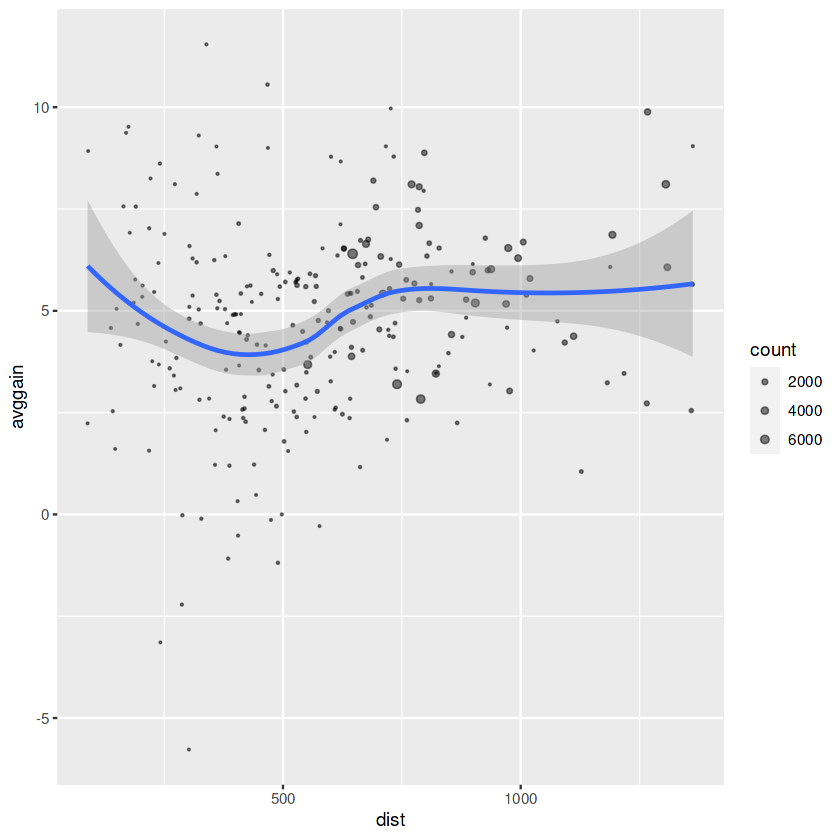

In [15]:
gains <- model_data_full %>%
  group_by(ORIGIN) %>%
  summarise(count = n(), dist = mean(DISTANCE), avggain = mean(GAIN)) %>%
  filter(count > 20, dist < 1500, !is.na(avggain)) %>%
  collect

# plot GAINs
ggplot(gains, aes(dist, avggain)) +
  geom_point(aes(size = count), alpha = 1/2) +
  geom_smooth() +
  scale_size_area(max_size = 2)

   user  system elapsed 
  0.016   0.001   0.018 

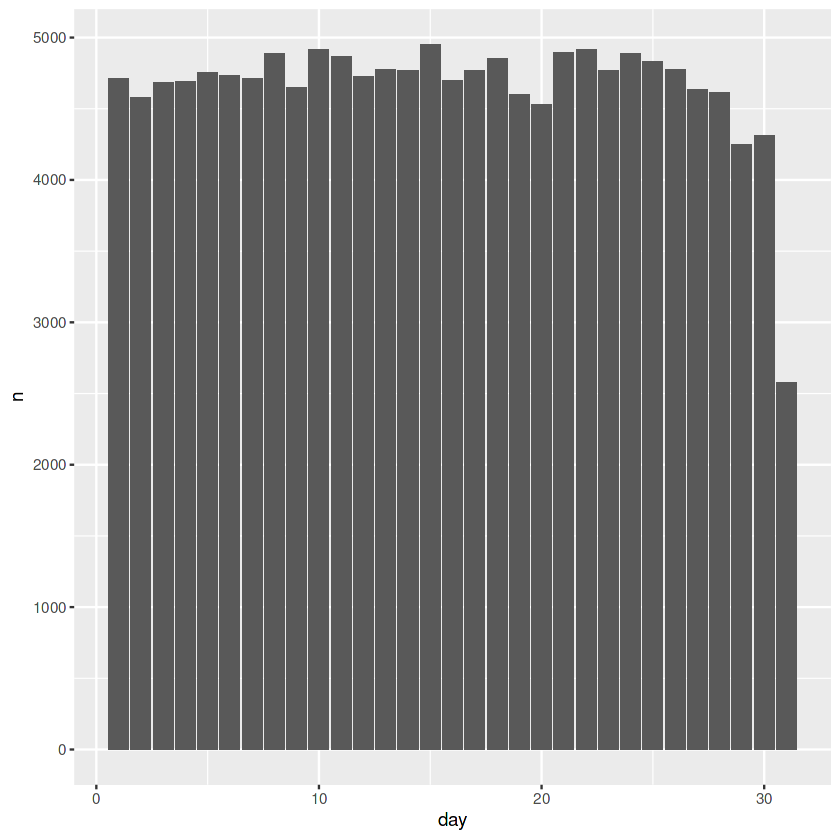

In [16]:
system.time({
out <- model_data_full %>%
  group_by(day) %>%
  count() %>%
  arrange(day) %>%
  collect()
})
out %>% ggplot(aes(x = day, y = n)) + geom_col()

In [17]:
partdaylabels<- c("Early Morning","Morning","Afternoon","Evening","Night")
distancelabels<- c("XXXS","XXS","XS","S","M","L","XL", "XXL", "XXXL", "XXXXL", "XXXXXL")

# Partition the data into training and validation sets
model_data_tbl <- copy_to(sc, model_data_full, "model_data_full", overwrite = TRUE) %>%
            ft_bucketizer(input_col  = "ARR_DELAY",
                          output_col = "DELAYED",
                          splits     = c(-60, 15, 360))%>%
mutate(DELAYEDchar = lpad(as.character(DELAYED), 1, "0"))%>%
            ft_bucketizer(input_col  = "DISTANCE",
                          output_col = "DISTANCE_GROUP",
        splits     = c(0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 100000)) %>% 
            ft_bucketizer(input_col  = "hour",
                          output_col = "PART_DAY",
                          splits     = c(0, 6, 12, 17, 21, 25))%>%
            ft_index_to_string("PART_DAY", "PART_DAY_LABEL", labels=partdaylabels)%>%
            ft_index_to_string("DISTANCE_GROUP", "DISTANCE_GROUP_LABEL", labels=distancelabels)


In [18]:
model_data_tbl%>%  filter(DISTANCE == 966) %>% select(DISTANCE, DISTANCE_GROUP, DISTANCE_GROUP_LABEL)

# Source: spark<?> [?? x 3]
   DISTANCE DISTANCE_GROUP DISTANCE_GROUP_LABEL
      <dbl>          <dbl> <chr>               
 1      966              3 S                   
 2      966              3 S                   
 3      966              3 S                   
 4      966              3 S                   
 5      966              3 S                   
 6      966              3 S                   
 7      966              3 S                   
 8      966              3 S                   
 9      966              3 S                   
10      966              3 S                   
# ℹ more rows

In [20]:
model_partition <- model_data_tbl %>% 
sdf_random_split(train = 0.8, test = 0.2, seed = 5555)

Comprobamos si el conjunto de test tiene etiquetas que no están en el conjunto de entrenamiento

In [21]:
a=which((collect(model_partition$test)$DEST %in% collect(model_partition$train)$DEST)==FALSE)
#Devuelve un vector con TRUE y FALSE en cada posición dependiendo de si el valor de esa posición en el primer vector 
#está en el segundo o no
v=collect(model_partition$test)$DEST[a] #Devuelve el valor del vector en las posiciones a.
v

[1] "GST" "BKG" "GST" "BKG"

In [22]:
a=which((collect(model_partition$test)$ORIGIN %in% collect(model_partition$train)$ORIGIN)==FALSE)
v2=collect(model_partition$test)$ORIGIN[a]
all(collect(model_partition$test)$ORIGIN %in% collect(model_partition$train)$ORIGIN)
#all comprueba si todos los valores de un vector son TRUE

[1] FALSE

Se puede ver que puede haber destinos en el conjunto de test que no están en el entrenamiento. Se procederá a retirar esas observaciones. Idem para orígenes.

In [23]:
model_partition$test<-model_partition$test %>% filter(!(DEST %in% v) )
model_partition$test<-model_partition$test %>% filter(!(ORIGIN %in% v2) )

In [ ]:
# Para comprobar que funciona part_day_label
# model_partition$train  %>% select(hour, PART_DAY, PART_DAY_LABEL)

In [24]:
sdf_schema(model_data_tbl)

$FL_DATE
$FL_DATE$name
[1] "FL_DATE"

$FL_DATE$type
[1] "StringType"


$Carrier
$Carrier$name
[1] "Carrier"

$Carrier$type
[1] "StringType"


$ORIGIN
$ORIGIN$name
[1] "ORIGIN"

$ORIGIN$type
[1] "StringType"


$DEST
$DEST$name
[1] "DEST"

$DEST$type
[1] "StringType"


$Name
$Name$name
[1] "Name"

$Name$type
[1] "StringType"


$DEP_DELAY
$DEP_DELAY$name
[1] "DEP_DELAY"

$DEP_DELAY$type
[1] "DoubleType"


$TAXI_OUT
$TAXI_OUT$name
[1] "TAXI_OUT"

$TAXI_OUT$type
[1] "DoubleType"


$DEP_DELAY_PLUS
$DEP_DELAY_PLUS$name
[1] "DEP_DELAY_PLUS"

$DEP_DELAY_PLUS$type
[1] "DoubleType"


$ARR_DELAY
$ARR_DELAY$name
[1] "ARR_DELAY"

$ARR_DELAY$type
[1] "DoubleType"


$DISTANCE
$DISTANCE$name
[1] "DISTANCE"

$DISTANCE$type
[1] "DoubleType"


$GAIN
$GAIN$name
[1] "GAIN"

$GAIN$type
[1] "DoubleType"


$year
$year$name
[1] "year"

$year$type
[1] "DoubleType"


$month
$month$name
[1] "month"

$month$type
[1] "DoubleType"


$day
$day$name
[1] "day"

$day$type
[1] "IntegerType"


$hour
$hour$name
[1] "hour"

$hour$type
[1] "DoubleType"


$wday
$wday$name
[1] "wday"

$wday$type
[1] "StringType"


$DELAYED
$DELAYED$name
[1] "DELAYED"

$DELAYED$type
[1] "DoubleType"


$DELAYEDchar
$DELAYEDchar$name
[1] "DELAYEDchar"

$DELAYEDchar$type
[1] "StringType"


$DISTANCE_GROUP
$DISTANCE_GROUP$name
[1] "DISTANCE_GROUP"

$DISTANCE_GROUP$type
[1] "DoubleType"


$PART_DAY
$PART_DAY$name
[1] "PART_DAY"

$PART_DAY$type
[1] "DoubleType"


$PART_DAY_LABEL
$PART_DAY_LABEL$name
[1] "PART_DAY_LABEL"

$PART_DAY_LABEL$type
[1] "StringType"


$DISTANCE_GROUP_LABEL
$DISTANCE_GROUP_LABEL$name
[1] "DISTANCE_GROUP_LABEL"

$DISTANCE_GROUP_LABEL$type
[1] "StringType"

# # Generating a Linear Model

In [25]:
# Fit a linear model (ARR_DELAY can not be used in any candidate model!! Used only for testing)
# FEATURES: FL_DATE, Carrier, ORIGIN, DEST, Name, DEP_DELAY, DEP_DELAY_PLUS, ARR_DELAY, DISTANCE, GAIN, year, month, day, hour,wday, 
#       derived FEATURES:  DELAYED, DISTANCE_GROUP, PART_DAY, PART_DAY_LABEL
system.time(
  ml1 <- model_partition$train %>%
    ml_linear_regression(GAIN ~ PART_DAY_LABEL+DISTANCE_GROUP_LABEL)
)

   user  system elapsed 
  1.216   0.011  12.711 

In [26]:
# Summarize the linear model
summary(ml1)


Deviance Residuals (approximate):
     Min       1Q   Median       3Q      Max 
-219.895   -5.834    1.593    7.919   60.726 

Coefficients:
               (Intercept)     PART_DAY_LABEL_Morning 
                11.1092168                 -0.8350465 
  PART_DAY_LABEL_Afternoon     PART_DAY_LABEL_Evening 
                -0.8567192                 -1.0311797 
      PART_DAY_LABEL_Night   DISTANCE_GROUP_LABEL_XXS 
                -0.5301654                 -5.4183839 
   DISTANCE_GROUP_LABEL_XS  DISTANCE_GROUP_LABEL_XXXS 
                -5.1718320                 -5.9100112 
    DISTANCE_GROUP_LABEL_S     DISTANCE_GROUP_LABEL_M 
                -4.6365904                 -3.6094441 
    DISTANCE_GROUP_LABEL_L  DISTANCE_GROUP_LABEL_XXXL 
                -3.1828001                 -2.2808248 
  DISTANCE_GROUP_LABEL_XXL    DISTANCE_GROUP_LABEL_XL 
                -2.0295997                 -2.4550101 
DISTANCE_GROUP_LABEL_XXXXL 
                -3.2891153 

R-Squared: 0.006021
Root Mean Sq

R-Squared: 0.02516
Root Mean Squared Error: 13.39

Voy a probar distintos tipos de modelos 

In [27]:
#VAMOS PROBANDO NUEVOS MODELOS. EL original solo usa 2 variables. Si intento mejorarlo sin añadir 
#más variables, es decir voy a probar otro modelo que solo use 2. Pruebo con ORIGIN  y Carrier
system.time(
  ml2 <- model_partition$train %>%
    ml_linear_regression(GAIN ~ ORIGIN+Carrier)
)

   user  system elapsed 
  1.178   0.016   9.981 

In [28]:
summary(ml2)

Deviance Residuals (approximate):
     Min       1Q   Median       3Q      Max 
-217.884   -5.649    1.411    7.744   62.239 

Coefficients:
                    (Intercept)                      ORIGIN_ATL 
                   -1.951840939                     2.772802462 
                     ORIGIN_ORD                      ORIGIN_DFW 
                    1.323477463                     0.796298777 
                     ORIGIN_DEN                      ORIGIN_CLT 
                    2.086565364                     1.588589302 
                     ORIGIN_LAX                      ORIGIN_IAH 
                    5.388271597                     2.150320209 
                     ORIGIN_PHX                      ORIGIN_LAS 
                    2.850045771                     3.070012798 
                     ORIGIN_LGA                      ORIGIN_SFO 
                    2.696199292                     4.518345309 
                     ORIGIN_MSP                      ORIGIN_DTW 
              

Vemos que el valor de R-Squared se ha quintuplicado aproximadamente. En ese sentido, este modelo es más eficiente.

In [29]:
predicted_gains_sc <- ml_predict(ml1, model_partition$test)
ml_regression_evaluator(predicted_gains_sc,  label_col = "GAIN", metric_name="r2")
#Poner "metric_name="opcion" para usar distintas métricas de validacion r2 mse mae...
predicted_gains <- predicted_gains_sc %>% collect()

predicted_gains %>% select(GAIN,prediction) %>% head(10)

[1] 0.005675405

GAIN,prediction
<dbl>,<dbl>
6,7.926417
5,4.168026
1,6.643054
-20,7.069698
0,5.407219
16,8.244571
2,8.222898
-4,4.855786
-3,5.407219


In [30]:
#Porcentaje de vuelos en el rango de 5, 10 y 15 min.
nflights = nrow(predicted_gains)
out <- predicted_gains %>% mutate(DeltaGAIN = abs (GAIN - prediction)) 
out %>% filter(DeltaGAIN <= 5) %>% count()/nflights
out %>% filter(DeltaGAIN <= 10) %>% count()/nflights
out %>% filter(DeltaGAIN <= 15) %>% count()/nflights

n
<dbl>
0.3707086


n
<dbl>
0.6517375


n
<dbl>
0.8203966


In [31]:
#Realizamos ahora predicted gains para el modelo 2 (GAIN~ORIGIN+Carrier) 
predicted_gains_sc2 <- ml_predict(ml2, model_partition$test)
ml_regression_evaluator(predicted_gains_sc2,  label_col = "GAIN", metric_name="r2")
#Poner "metric_name="opcion" para usar distintas métricas de validacion r2 mse mae...
predicted_gains2 <- predicted_gains_sc2 %>% collect()

predicted_gains2 %>% select(GAIN,prediction) %>% head(10)

[1] 0.02141949

GAIN,prediction
<dbl>,<dbl>
6,5.382058
5,4.424794
1,5.803030
-20,1.367242
0,4.186059
16,7.985741
2,7.985741
-4,4.258002
-3,5.447515


In [32]:
#Porcentaje de vuelos en el rango de 5, 10 y 15 min, ahora con el modelo ml2.
nflights = nrow(predicted_gains2)
out <- predicted_gains2 %>% mutate(DeltaGAIN = abs (GAIN - prediction)) 
out %>% filter(DeltaGAIN <= 5) %>% count()/nflights
out %>% filter(DeltaGAIN <= 10) %>% count()/nflights
out %>% filter(DeltaGAIN <= 15) %>% count()/nflights

n
<dbl>
0.3805375


n
<dbl>
0.6600676


n
<dbl>
0.8219302


In [33]:
##Ahora vamos a probar a ajustar un modelo de regresion que incluya más variables
#pero incluyendo las 2 usadas en ml2 (en la literatura a esto se le llama un forward method)
#Como tener en cuenta ORIGIN ha surtido "comparativamente buen efecto" voy a incluir también la variable
# DEST, la idea es que igual se están teniendo en cuenta "aeropuertos malos de salida" al incluir ORIGIN
#Al incluir DEST espero que se valore que el aeropuerto de llegada también sea "Malo"
#Añado también DISTANCE_GROUP, creo que viajar más lejos implica que hay mas oportunidades de que ocurran 
# incidencias durante el vuelo. Sin embargo me gustaria ajustar el modelo respecto a la raiz cuadrada
# de las distancias.
system.time(
  mlm3 <- model_partition$train %>%
    ml_linear_regression(GAIN ~ ORIGIN+Carrier+DEST+DISTANCE_GROUP)
)

   user  system elapsed 
  1.214   0.014  10.192 

In [34]:
summary(mlm3)

Deviance Residuals (approximate):
     Min       1Q   Median       3Q      Max 
-216.975   -5.603    1.556    7.771   58.034 

Coefficients:
                    (Intercept)                      ORIGIN_ATL 
                     13.1584620                       3.5356421 
                     ORIGIN_ORD                      ORIGIN_DFW 
                      1.5586173                       1.4457610 
                     ORIGIN_DEN                      ORIGIN_CLT 
                      2.1528488                       2.6591318 
                     ORIGIN_LAX                      ORIGIN_IAH 
                      4.9617348                       2.1933756 
                     ORIGIN_PHX                      ORIGIN_LAS 
                      3.1811650                       3.2166333 
                     ORIGIN_LGA                      ORIGIN_SFO 
                      3.0869196                       4.2941974 
                     ORIGIN_MSP                      ORIGIN_DTW 
              

In [35]:
#Realizamos ahora predicted gains para el modelo 3 (GAIN~ORIGIN+Carrier+DEST+DISTANCE_GROUP) 
predicted_gains_sc3 <- ml_predict(mlm3, model_partition$test)
ml_regression_evaluator(predicted_gains_sc3,  label_col = "GAIN", metric_name="r2")
#Poner "metric_name="opcion" para usar distintas métricas de validacion r2 mse mae...
predicted_gains3 <- predicted_gains_sc3 %>% collect()

predicted_gains3 %>% select(GAIN,prediction) %>% head(10)

[1] 0.02937608

GAIN,prediction
<dbl>,<dbl>
6,5.910663
5,1.134147
1,11.059309
-20,1.519565
0,5.031710
16,10.887768
2,10.134660
-4,4.408958
-3,6.193192


In [36]:
#Porcentaje de vuelos en el rango de 5, 10 y 15 min, ahora con el modelo mlm3.
nflights = nrow(predicted_gains3)
out <- predicted_gains3 %>% mutate(DeltaGAIN = abs (GAIN - prediction)) 
out %>% filter(DeltaGAIN <= 5) %>% count()/nflights
out %>% filter(DeltaGAIN <= 10) %>% count()/nflights
out %>% filter(DeltaGAIN <= 15) %>% count()/nflights

n
<dbl>
0.3793524


n
<dbl>
0.6602767


n
<dbl>
0.8250671


In [38]:
#Vamos a incorporar la variable TAXI_OUT, junto a otras variables. Tener en cuenta que, TAXI_OUT 
#es un valor que solo sabemos una vez despegamos. Por tanto los modelos que incluyan esa variable
# no sirven para hacer predicciones antes de dicho momento.
system.time(
  mlm4 <- model_partition$train %>%
    ml_linear_regression(GAIN ~ ORIGIN+Carrier+DEST+DISTANCE_GROUP+TAXI_OUT+PART_DAY_LABEL+wday)
)

   user  system elapsed 
  1.168   0.013  12.157 

In [ ]:
summary(mlm4)

In [41]:
#Realizamos ahora predicted gains para el modelo 4 (GAIN~ORIGIN+Carrier+DEST+DISTANCE_GROUP+TAXI_OUT
# +PART_DAY_LABEL+wday) 
predicted_gains_sc4 <- ml_predict(mlm4, model_partition$test)
ml_regression_evaluator(predicted_gains_sc4,  label_col = "GAIN", metric_name="r2")
#Poner "metric_name="opcion" para usar distintas métricas de validacion r2 mse mae...
predicted_gains4 <- predicted_gains_sc4 %>% collect()

predicted_gains4 %>% select(GAIN,prediction) %>% head(10)

[1] 0.4311017

GAIN,prediction
<dbl>,<dbl>
6,-2.639426
5,7.081761
1,8.167800
-20,6.133764
0,7.459266
16,14.478233
2,11.778992
-4,4.576484
-3,-2.961019


In [42]:
#Porcentaje de vuelos en el rango de 5, 10 y 15 min, ahora con el modelo mlm3.
nflights = nrow(predicted_gains4)
out <- predicted_gains4 %>% mutate(DeltaGAIN = abs (GAIN - prediction)) 
out %>% filter(DeltaGAIN <= 5) %>% count()/nflights
out %>% filter(DeltaGAIN <= 10) %>% count()/nflights
out %>% filter(DeltaGAIN <= 15) %>% count()/nflights

n
<dbl>
0.4722038


n
<dbl>
0.7600641


n
<dbl>
0.8969363


In [43]:
# Ahora vamos a ver si la causa fue tanto por el TAXI_OUT o por las nuevas variables que habíamos añadido
#(backward method)
system.time(
  mlm5 <- model_partition$train %>%
    ml_linear_regression(GAIN ~ ORIGIN+Carrier+DEST+DISTANCE_GROUP+PART_DAY_LABEL+wday)
)

   user  system elapsed 
  1.131   0.021  11.848 

In [ ]:
summary(mlm5)

In [44]:
#Realizamos ahora predicted gains para el modelo 5 (GAIN~ORIGIN+Carrier+DEST+DISTANCE_GROUP+TAXI_OUT
# +PART_DAY_LABEL+wday) 
predicted_gains_sc5 <- ml_predict(mlm5, model_partition$test)
ml_regression_evaluator(predicted_gains_sc5,  label_col = "GAIN", metric_name="r2")
#Poner "metric_name="opcion" para usar distintas métricas de validacion r2 mse mae...
predicted_gains5 <- predicted_gains_sc5 %>% collect()

predicted_gains5 %>% select(GAIN,prediction) %>% head(10)

[1] 0.03091535

GAIN,prediction
<dbl>,<dbl>
6,6.4482754
5,0.9366294
1,11.0541353
-20,1.7206313
0,5.1257821
16,10.8244076
2,10.1952775
-4,4.3622287
-3,6.2430240


In [45]:
#Porcentaje de vuelos en el rango de 5, 10 y 15 min, ahora con el modelo mlm3.
nflights = nrow(predicted_gains5)
out <- predicted_gains5 %>% mutate(DeltaGAIN = abs (GAIN - prediction)) 
out %>% filter(DeltaGAIN <= 5) %>% count()/nflights
out %>% filter(DeltaGAIN <= 10) %>% count()/nflights
out %>% filter(DeltaGAIN <= 15) %>% count()/nflights

n
<dbl>
0.3817573


n
<dbl>
0.6611829


n
<dbl>
0.8252065


Record of models: 

ml2 (en el apartado de random forest se reutiliza este nombre, tener cuidado para evitar errores o confusiones) 
ml2 sigue la estructura (GAINS~ORIGIN+Carrier) 
R^2=0.02787 RMSE 13.48    proporciones  5min: 0.3777662 10min:0.6572574 15min:0.8214672

mlm3 (GAINS~ORIGIN+Carrier+DEST+DISTANCE_GROUP
R^2=0.038833 RMSE 13.41   proporciones  5min: 0.378951 10min:0.6566649 15min:0.8249172

Vemos que mlm3 parece predecir mejor los deltagains en 5 y 15 minutos pero peor en 10 minutos
Sin embargo la diferencia es tán ligera que uno puede sospechar que es producto del azar

mlm4(GAINS~ORIGIN+Carrier+DEST+DISTANCE_GROUP+TAXI_OUT+PART_DAY_LABEL+wday)
R^2=0.4435 RMSE=10.2 proporciones 5min: 0.4668061 10min:0.75839 15min:0.8909915

Vemos que incluir las nuevas variables ha hecho mejorar muy significativamente el modelo.

mlm5(GAINS~ORIGIN+Carrier+DEST+DISTANCE_GROUP+PART_DAY_LABEL+wday)
R^2=0.04025 RMSE=13.4    proporciones  5min: 0.3782192 10min:0.6577453 15min:0.8242551

Vemos que efectivamente era todo a causa de haber añadido TAXI_OUT en el modelo. Pues hemos vuelto
a valores muy similares de los obtenidos en el modelo mlm3


Candidate LM models:

GAIN ~ DISTANCE + hour     
R^2 0.0066    5-10-15 minutes: 0.3676747  0.6484914   0.8145774 



GAIN ~ DISTANCE_GROUP + PART_DAY + Carrier + PART_DAY_LABEL+wday
R^2 0.02331   5-10-15 minutes: 0.3781911 0.6599798  0.8239473

+++++ GAIN ~ FL_DATE+ Carrier + DISTANCE_GROUP + PART_DAY_LABEL   (FL_DATE non é aplicable)
R-Squared: 0.04156   RMSE: 13.28   0.3778219 0.6569468 0.8243102  R^2 ajustado

In [ ]:
# R^2 ajustado:   1-((n-1)/((n-1-k))*(1-R^2)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


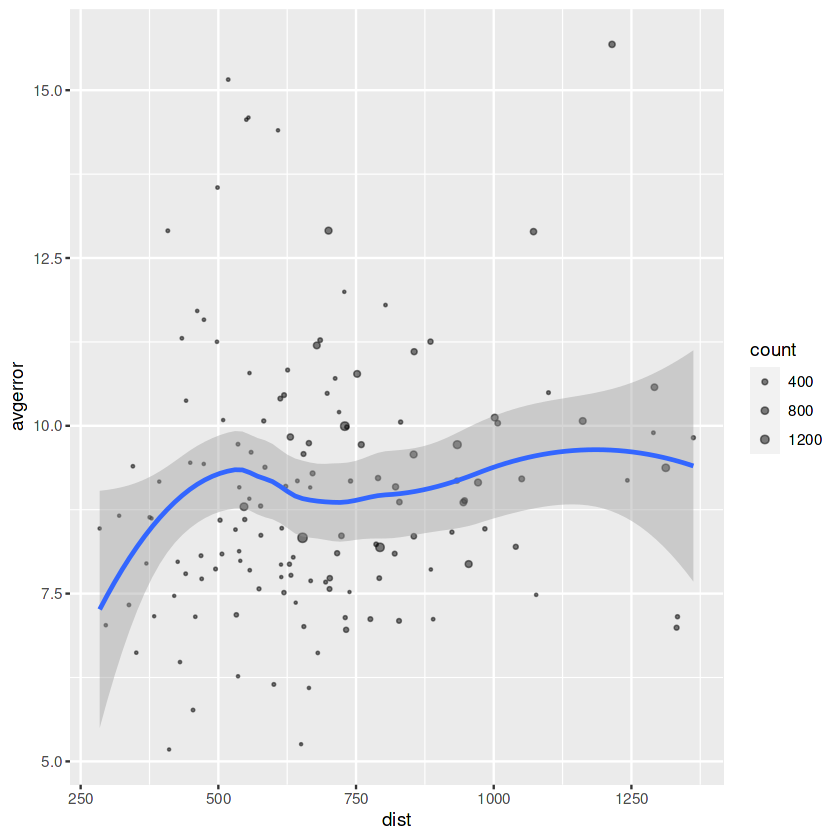

In [46]:
predicted_gains_tbp <- predicted_gains %>%
  group_by(ORIGIN) %>%
  summarise(count = n(), dist = mean(DISTANCE), avgerror = mean(abs(GAIN - prediction))) %>%
  filter(count > 20, dist < 1500, !is.na(avgerror)) %>%
  collect

# plot GAINs
ggplot(predicted_gains_tbp, aes(dist, avgerror)) +
  geom_point(aes(size = count), alpha = 1/2) +
  geom_smooth() +
  scale_size_area(max_size = 2)

Los distintos gráficos para cada modelo:

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


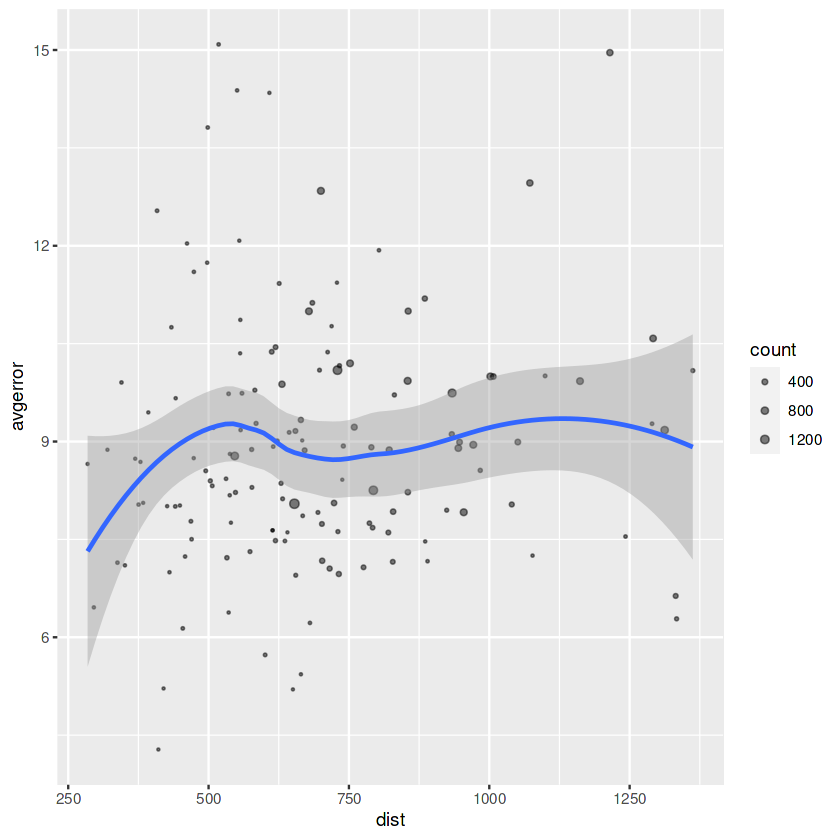

In [47]:
predicted_gains_tbp <- predicted_gains2 %>%
  group_by(ORIGIN) %>%
  summarise(count = n(), dist = mean(DISTANCE), avgerror = mean(abs(GAIN - prediction))) %>%
  filter(count > 20, dist < 1500, !is.na(avgerror)) %>%
  collect

# plot GAINs
ggplot(predicted_gains_tbp, aes(dist, avgerror)) +
  geom_point(aes(size = count), alpha = 1/2) +
  geom_smooth() +
  scale_size_area(max_size = 2)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


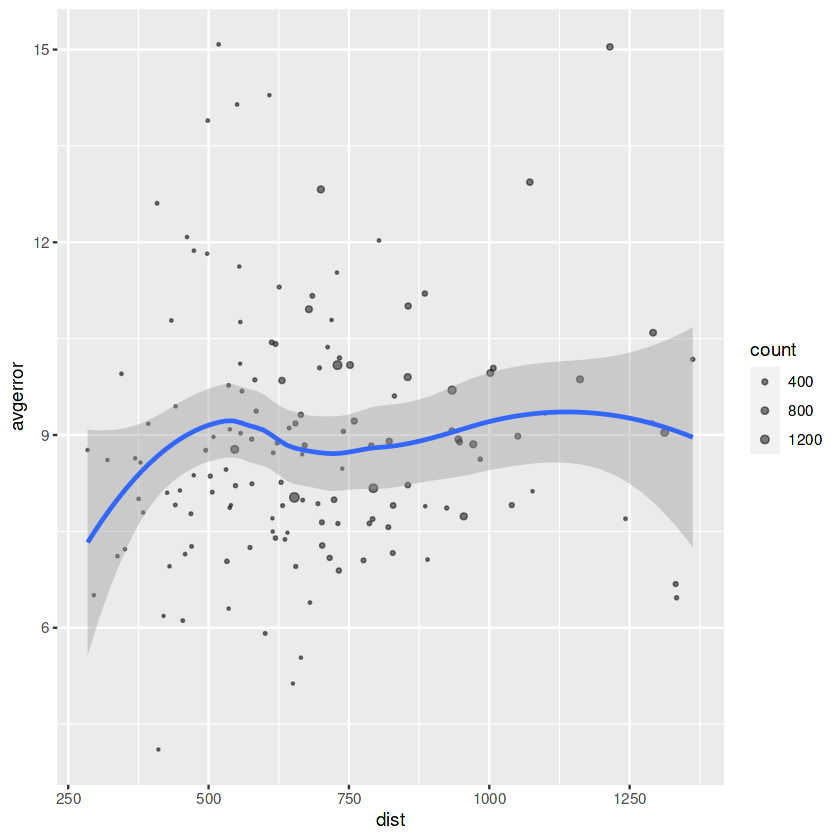

In [48]:
predicted_gains_tbp <- predicted_gains3 %>%
  group_by(ORIGIN) %>%
  summarise(count = n(), dist = mean(DISTANCE), avgerror = mean(abs(GAIN - prediction))) %>%
  filter(count > 20, dist < 1500, !is.na(avgerror)) %>%
  collect

# plot GAINs
ggplot(predicted_gains_tbp, aes(dist, avgerror)) +
  geom_point(aes(size = count), alpha = 1/2) +
  geom_smooth() +
  scale_size_area(max_size = 2)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


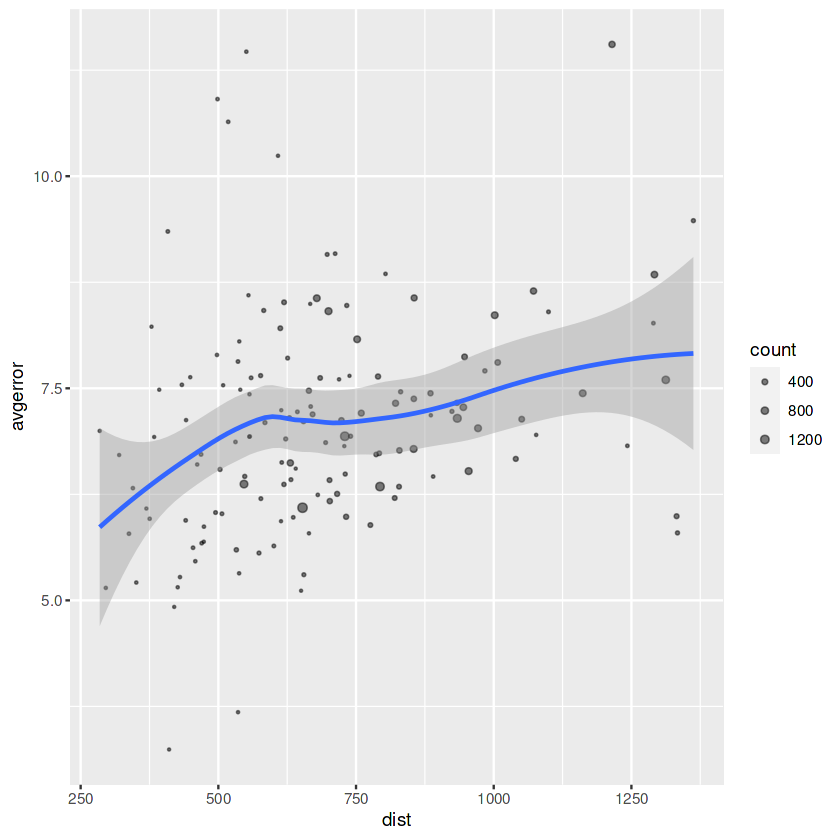

In [49]:
predicted_gains_tbp <- predicted_gains4 %>%
  group_by(ORIGIN) %>%
  summarise(count = n(), dist = mean(DISTANCE), avgerror = mean(abs(GAIN - prediction))) %>%
  filter(count > 20, dist < 1500, !is.na(avgerror)) %>%
  collect

# plot GAINs
ggplot(predicted_gains_tbp, aes(dist, avgerror)) +
  geom_point(aes(size = count), alpha = 1/2) +
  geom_smooth() +
  scale_size_area(max_size = 2)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


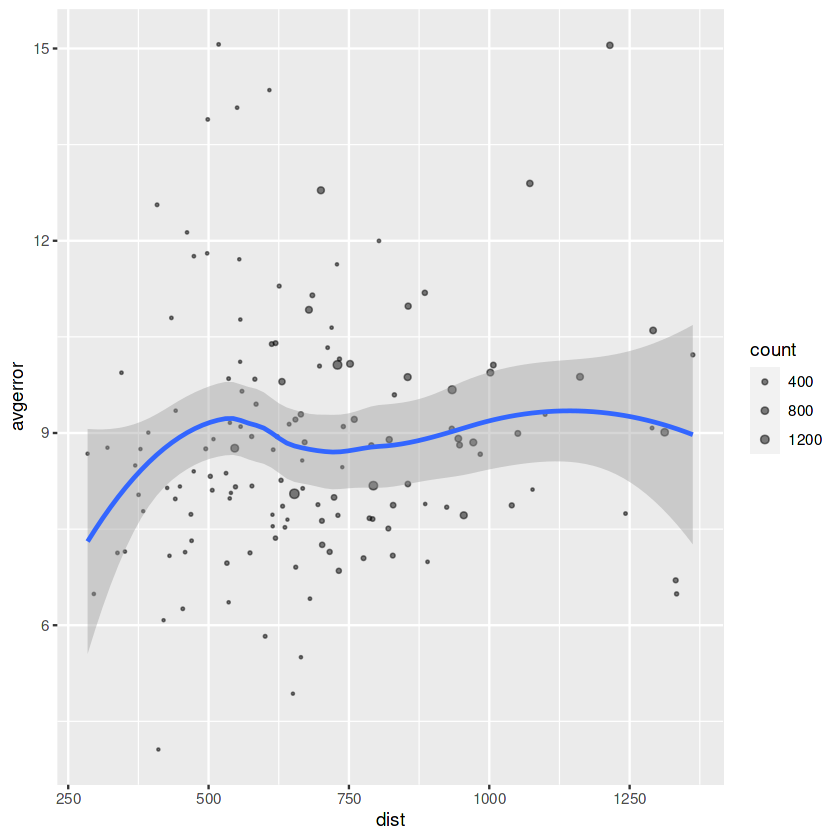

In [50]:
predicted_gains_tbp <- predicted_gains5 %>%
  group_by(ORIGIN) %>%
  summarise(count = n(), dist = mean(DISTANCE), avgerror = mean(abs(GAIN - prediction))) %>%
  filter(count > 20, dist < 1500, !is.na(avgerror)) %>%
  collect

# plot GAINs
ggplot(predicted_gains_tbp, aes(dist, avgerror)) +
  geom_point(aes(size = count), alpha = 1/2) +
  geom_smooth() +
  scale_size_area(max_size = 2)

**Trying Random Forest**

In [51]:
# Fit a RF model (ARR_DELAY can not be used in any candidate model!! Used only for testing)
system.time(
  ml2 <- model_partition$train %>%
    ml_random_forest(GAIN ~ DISTANCE_GROUP_LABEL +Carrier + PART_DAY_LABEL+wday, type = "regression")
)

   user  system elapsed 
  0.756   0.003  16.351 

In [ ]:
# Summarize the RF model
summary(ml2)

In [52]:
predicted_gains_sc <- ml_predict(ml2, model_partition$test)
ml_regression_evaluator(predicted_gains_sc,  label_col = "GAIN")

predicted_gains <- predicted_gains_sc %>% collect()


[1] 13.37946

In [53]:
#Porcentaje de vuelos en el rango de 5, 10 y 15 min.
nflights = nrow(predicted_gains)
out <- predicted_gains %>% mutate(DeltaGAIN = abs (GAIN - prediction)) 
out %>% filter(DeltaGAIN <= 5) %>% count()/nflights
out %>% filter(DeltaGAIN <= 10) %>% count()/nflights
out %>% filter(DeltaGAIN <= 15) %>% count()/nflights

n
<dbl>
0.3785508


n
<dbl>
0.6563731


n
<dbl>
0.8205361


In [ ]:
#head(predicted_gains)

In [54]:
#Voy a realizar un random forest con un modelo que use las mismas variables que mlm4 que fue
# el que mejor resultado dio en el anterior apartado
system.time(
  mlf2 <- model_partition$train %>%
    ml_random_forest(GAIN~ORIGIN+Carrier+DEST+DISTANCE_GROUP+TAXI_OUT+PART_DAY_LABEL+wday, type = "regression")
)

   user  system elapsed 
  0.869   0.010  54.133 

In [ ]:
summary(mlf2)

In [55]:
predicted_gains_scf <- ml_predict(mlf2, model_partition$test)
ml_regression_evaluator(predicted_gains_sc,  label_col = "GAIN")

predicted_gainsf <- predicted_gains_scf %>% collect()


[1] 13.37946

In [56]:
#Porcentaje de vuelos en el rango de 5, 10 y 15 min.
nflights = nrow(predicted_gainsf)
out <- predicted_gainsf %>% mutate(DeltaGAIN = abs (GAIN - prediction)) 
out %>% filter(DeltaGAIN <= 5) %>% count()/nflights
out %>% filter(DeltaGAIN <= 10) %>% count()/nflights
out %>% filter(DeltaGAIN <= 15) %>% count()/nflights

n
<dbl>
0.4245582


n
<dbl>
0.7125579


n
<dbl>
0.8642431


Vemos valores inferiores a los obtenidos con las mismas variables en el modelo de regresion. Sin embargo son ceercanos

# # Naive Bayes


In [57]:
# Fit a naive bayes model 
# FEATURES: FL_DATE, Carrier, ORIGIN, DEST, Name, DEP_DELAY, DEP_DELAY_PLUS, ARR_DELAY, DISTANCE, 
# GAIN, year, month, day, hour,wday, 
#       derived FEATURES:  DELAYED, DISTANCE_GROUP, PART_DAY, PART_DAY_LABEL
system.time(
  nb_model <- ml_naive_bayes(x=model_partition$train,
    DELAYED~DISTANCE+PART_DAY_LABEL+wday+hour+day+DEP_DELAY_PLUS)
)

   user  system elapsed 
  1.015   0.018   6.077 

In [58]:
system.time(
  nb_model_predictions <- ml_predict(nb_model,model_partition$test) 
)
ml_multiclass_classification_evaluator(nb_model_predictions, label_col = "DELAYED",)


   user  system elapsed 
  0.320   0.002   0.636 

[1] 0.6452222

In [59]:
nb_model_predictions %>% filter (prediction==1) %>% 
select (DELAYED, prediction, probability_0, DISTANCE_GROUP_LABEL,PART_DAY_LABEL)

# Source: spark<?> [?? x 5]
   DELAYED prediction probability_0 DISTANCE_GROUP_LABEL PART_DAY_LABEL
     <dbl>      <dbl>         <dbl> <chr>                <chr>         
 1       0          1      2.29e- 8 XXXS                 Evening       
 2       0          1      7.89e- 2 XXS                  Morning       
 3       0          1      2.37e- 8 XXXS                 Evening       
 4       0          1      2.03e- 1 XXS                  Early Morning 
 5       0          1      7.06e- 4 XXS                  Afternoon     
 6       0          1      5.62e- 7 XXXS                 Morning       
 7       1          1      2.18e-25 XS                   Afternoon     
 8       0          1      2.95e- 9 XXXS                 Afternoon     
 9       0          1      2.32e- 3 XXS                  Morning       
10       0          1      4.65e- 1 XS                   Afternoon     
# ℹ more rows

In [60]:
nb_model_predictions %>% 
select(DELAYED, prediction, probability_0, DEP_DELAY_PLUS) %>%
filter(prediction==1) %>% 
head(n=10)

#filter(prediction==1) %>% count()

# Source: spark<?> [?? x 4]
   DELAYED prediction probability_0 DEP_DELAY_PLUS
     <dbl>      <dbl>         <dbl>          <dbl>
 1       0          1      2.29e- 8             54
 2       0          1      7.89e- 2             54
 3       0          1      2.37e- 8             54
 4       0          1      2.03e- 1             55
 5       0          1      7.06e- 4             60
 6       0          1      5.62e- 7             55
 7       1          1      2.18e-25            163
 8       0          1      2.95e- 9             55
 9       0          1      2.32e- 3             58
10       0          1      4.65e- 1             77

In [61]:
# aquí sae o valor de TPR (TP/P) e TNR (TN/N)
prediccion_nb <- nb_model_predictions %>%
    group_by(DELAYED, prediction) %>%
    summarise(n=n()) %>%
    mutate(freq=n/sum(n)) %>% collect
prediccion_nb

`summarise()` has grouped output by "DELAYED". You can override using the
`.groups` argument.
Warning message:
“Missing values are always removed in SQL aggregation functions.
Use `na.rm = TRUE` to silence this warning
This warning is displayed once every 8 hours.”


DELAYED,prediction,n,freq
<dbl>,<dbl>,<dbl>,<dbl>
0,1,9817,0.4172653
0,0,13710,0.5827347
1,0,1695,0.3282339
1,1,3469,0.6717661


In [62]:
# aquí sae o valor de Prediction
prediccion_nb <- nb_model_predictions %>%
    group_by(prediction, DELAYED) %>%
    summarise(n=n()) %>%
    mutate(freq=n/sum(n)) %>% collect
prediccion_nb

`summarise()` has grouped output by "prediction". You can override using the
`.groups` argument.


prediction,DELAYED,n,freq
<dbl>,<dbl>,<dbl>,<dbl>
0,1,1695,0.1100292
0,0,13710,0.8899708
1,0,9817,0.7388981
1,1,3469,0.2611019


In [63]:
##Vamos a poner a prueba algunos modelos usados antes con gain, ahora con naive bayes y con delayed

system.time(
  nb_model2 <- ml_naive_bayes(x=model_partition$train,
    DELAYED~ORIGIN+Carrier)
)

   user  system elapsed 
  1.024   0.011   5.931 

In [64]:
system.time(
  nb_model_predictions2 <- ml_predict(nb_model2,model_partition$test) 
)
ml_multiclass_classification_evaluator(nb_model_predictions2, label_col = "DELAYED",)


   user  system elapsed 
  0.306   0.000   0.578 

[1] 0.7389023

In [65]:
nb_model_predictions2 %>% filter (prediction==1) %>% 
select (DELAYED, prediction, probability_0, DISTANCE_GROUP_LABEL,PART_DAY_LABEL)

# Source: spark<?> [?? x 5]
  DELAYED prediction probability_0 DISTANCE_GROUP_LABEL PART_DAY_LABEL
    <dbl>      <dbl>         <dbl> <chr>                <chr>         
1       0          1         0.440 XXXS                 Afternoon     

In [66]:
nb_model_predictions2 %>% 
select(DELAYED, prediction, probability_0, DEP_DELAY_PLUS) %>%
filter(prediction==1) %>% 
head(n=10)

# Source: spark<?> [?? x 4]
  DELAYED prediction probability_0 DEP_DELAY_PLUS
    <dbl>      <dbl>         <dbl>          <dbl>
1       0          1         0.440             56

In [67]:
prediccion_nb2 <- nb_model_predictions2 %>%
    group_by(DELAYED, prediction) %>%
    summarise(n=n()) %>%
    mutate(freq=n/sum(n)) %>% collect
prediccion_nb2

`summarise()` has grouped output by "DELAYED". You can override using the
`.groups` argument.


DELAYED,prediction,n,freq
<dbl>,<dbl>,<dbl>,<dbl>
0,1,1,4.250436e-05
0,0,23526,9.999575e-01
1,0,5164,1.000000e+00


In [68]:
prediccion_nb2 <- nb_model_predictions2 %>%
    group_by(prediction, DELAYED) %>%
    summarise(n=n()) %>%
    mutate(freq=n/sum(n)) %>% collect
prediccion_nb2

`summarise()` has grouped output by "prediction". You can override using the
`.groups` argument.


prediction,DELAYED,n,freq
<dbl>,<dbl>,<dbl>,<dbl>
0,1,5164,0.179993
0,0,23526,0.820007
1,0,1,1.000000


Bueno parece que este modelo simplemente dice que nada va a retrasarse (salvo 2 vuelos donde se ha equivocado) no parece ser muy idóneo

In [69]:
###Vamos a probar con el esquema que usa las mismas variables explicativas que mlm4, que fue el que mejor
# funcionó como modelo de regresión lineal
system.time(
  nb_model3 <- ml_naive_bayes(x=model_partition$train,
    DELAYED~ORIGIN+Carrier+DEST+DISTANCE_GROUP+TAXI_OUT+PART_DAY_LABEL+wday)
)

   user  system elapsed 
  0.968   0.010   9.258 

In [70]:
system.time(
  nb_model_predictions3 <- ml_predict(nb_model3,model_partition$test) 
)
ml_multiclass_classification_evaluator(nb_model_predictions3, label_col = "DELAYED",)

   user  system elapsed 
  0.321   0.002   0.663 

[1] 0.7914621

In [71]:
nb_model_predictions3 %>% filter (prediction==1) %>% 
select (DELAYED, prediction, probability_0, DISTANCE_GROUP_LABEL,PART_DAY_LABEL)

# Source: spark<?> [?? x 5]
   DELAYED prediction probability_0 DISTANCE_GROUP_LABEL PART_DAY_LABEL
     <dbl>      <dbl>         <dbl> <chr>                <chr>         
 1       1          1         0.174 XS                   Afternoon     
 2       1          1         0.179 XS                   Morning       
 3       1          1         0.284 XXXS                 Evening       
 4       0          1         0.468 XXS                  Morning       
 5       1          1         0.488 S                    Evening       
 6       1          1         0.408 XXXS                 Evening       
 7       1          1         0.133 XXXS                 Afternoon     
 8       0          1         0.238 XXXS                 Afternoon     
 9       1          1         0.364 XXXS                 Evening       
10       1          1         0.284 XXS                  Morning       
# ℹ more rows

In [72]:
nb_model_predictions3 %>% 
select(DELAYED, prediction, probability_0, DEP_DELAY_PLUS) %>%
filter(prediction==1) %>% 
head(n=10)

# Source: spark<?> [?? x 4]
   DELAYED prediction probability_0 DEP_DELAY_PLUS
     <dbl>      <dbl>         <dbl>          <dbl>
 1       1          1         0.174            163
 2       1          1         0.179            158
 3       1          1         0.284             73
 4       0          1         0.468             49
 5       1          1         0.488             57
 6       1          1         0.408             59
 7       1          1         0.133             63
 8       0          1         0.238             57
 9       1          1         0.364             71
10       1          1         0.284             73

In [73]:
prediccion_nb3 <- nb_model_predictions3 %>%
    group_by(DELAYED, prediction) %>%
    summarise(n=n()) %>%
    mutate(freq=n/sum(n)) %>% collect
prediccion_nb3

`summarise()` has grouped output by "DELAYED". You can override using the
`.groups` argument.


DELAYED,prediction,n,freq
<dbl>,<dbl>,<dbl>,<dbl>
0,1,1059,0.04501211
0,0,22468,0.95498789
1,0,4041,0.78253292
1,1,1123,0.21746708


In [74]:
prediccion_nb3 <- nb_model_predictions3 %>%
    group_by(prediction, DELAYED) %>%
    summarise(n=n()) %>%
    mutate(freq=n/sum(n)) %>% collect
prediccion_nb3

`summarise()` has grouped output by "prediction". You can override using the
`.groups` argument.


prediction,DELAYED,n,freq
<dbl>,<dbl>,<dbl>,<dbl>
0,1,4041,0.1524388
0,0,22468,0.8475612
1,1,1123,0.5146654
1,0,1059,0.4853346


Vemos un comportamiento mucho mejor aquí que en el modelo propuesto. Notar que si predice que un vuelo se va a retrasar, la probabilidad de que sí se retrase es de un 53%. Puede no parecer gran cosa pero hay que fijarse en que la cantidad de vuelos que no se retrasan es mucho mayor. Solo un 18% de los vuelos se retrasan. Si tuvieramos que señalar un vuelo que se fuese a retrasar "a ciegas" solo acertaríamos en un 18% de los casos. Sin embargo usando este modelo acertaríamos un 53% de las veces. Por otra parte el modelo propuesto inicialmente en el las celdas ya escritas previamente mejora la probabilidad de un 18% a un 27%, así que tampoco es que fuese horrible.

In [75]:
#Pasamos a probar un modelo con las mismas variables que el mlm5 usando en regresion lineal
system.time(
  nb_model4 <- ml_naive_bayes(x=model_partition$train,
    DELAYED~ORIGIN+Carrier+DEST+DISTANCE_GROUP+PART_DAY_LABEL+wday)
)

   user  system elapsed 
  1.087   0.008   9.414 

In [76]:
system.time(
  nb_model_predictions4 <- ml_predict(nb_model4,model_partition$test) 
)
ml_multiclass_classification_evaluator(nb_model_predictions4, label_col = "DELAYED",)

   user  system elapsed 
  0.337   0.000   0.652 

[1] 0.7432473

In [77]:
nb_model_predictions4 %>% filter (prediction==1) %>% 
select (DELAYED, prediction, probability_0, DISTANCE_GROUP_LABEL,PART_DAY_LABEL)

# Source: spark<?> [?? x 5]
   DELAYED prediction probability_0 DISTANCE_GROUP_LABEL PART_DAY_LABEL
     <dbl>      <dbl>         <dbl> <chr>                <chr>         
 1       0          1         0.500 XXXS                 Night         
 2       0          1         0.409 S                    Night         
 3       1          1         0.478 S                    Night         
 4       1          1         0.460 XS                   Night         
 5       0          1         0.460 M                    Night         
 6       0          1         0.455 XXS                  Night         
 7       1          1         0.400 S                    Night         
 8       1          1         0.434 XS                   Night         
 9       1          1         0.492 XXS                  Evening       
10       0          1         0.483 S                    Evening       
# ℹ more rows

In [78]:
nb_model_predictions4 %>% 
select(DELAYED, prediction, probability_0, DEP_DELAY_PLUS) %>%
filter(prediction==1) %>% 
head(n=10)


# Source: spark<?> [?? x 4]
   DELAYED prediction probability_0 DEP_DELAY_PLUS
     <dbl>      <dbl>         <dbl>          <dbl>
 1       0          1         0.500             49
 2       0          1         0.409             66
 3       1          1         0.478             86
 4       1          1         0.460            107
 5       0          1         0.460             59
 6       0          1         0.455             73
 7       1          1         0.400            118
 8       1          1         0.434            262
 9       1          1         0.492            143
10       0          1         0.483             48

In [79]:
prediccion_nb4 <- nb_model_predictions4 %>%
    group_by(DELAYED, prediction) %>%
    summarise(n=n()) %>%
    mutate(freq=n/sum(n)) %>% collect
prediccion_nb4

`summarise()` has grouped output by "DELAYED". You can override using the
`.groups` argument.


DELAYED,prediction,n,freq
<dbl>,<dbl>,<dbl>,<dbl>
0,1,121,0.005143027
0,0,23406,0.994856973
1,0,5085,0.984701782
1,1,79,0.015298218


In [80]:
prediccion_nb4 <- nb_model_predictions4 %>%
    group_by(prediction, DELAYED) %>%
    summarise(n=n()) %>%
    mutate(freq=n/sum(n)) %>% collect
prediccion_nb4

`summarise()` has grouped output by "prediction". You can override using the
`.groups` argument.


prediction,DELAYED,n,freq
<dbl>,<dbl>,<dbl>,<dbl>
0,1,5085,0.1784774
0,0,23406,0.8215226
1,0,121,0.6050000
1,1,79,0.3950000


Aquí el modelo señala a retrasarse a demasiados pocos vuelos. Si bien es cierto que la proporción de retrasos ha subido del 18% al 42%. Si tenemos que señalar un avión que no se vaya a retrasar "al azar" tendríamos un 81.5% de acertar y escogiendo del modelo tendríamos  un 81.7%  de acertar. Así que en ese sentido este método no mejora mucho la predicción de "no retrasarse"


**Trying Random Forest**

In [ ]:
# Fit a RF model 
system.time(
  rf_model <- model_partition$train %>%
    ml_random_forest(DELAYED~DISTANCE_GROUP_LABEL+DEP_DELAY_PLUS+PART_DAY_LABEL+month+wday, type = "classification")
)

In [ ]:
system.time(
  rf_model_predictions <- ml_predict(rf_model,model_partition$test) 
)
ml_multiclass_classification_evaluator(rf_model_predictions)

ojo meter rf en vez de nb en la ultima linea, eso es una errata

In [ ]:
prediccion_nb <- rf_model_predictions %>%
    group_by(DELAYED, prediction) %>%
    summarise(n=n()) %>%
    mutate(freq=n/sum(n)) %>% collect
prediccion_nb

In [ ]:
#Vamos a ajustar un modelo de random forest que use las variables que mejor han funcionado por ahora
system.time(
  rf_model6 <- model_partition$train %>%
    ml_random_forest(DELAYED~ORIGIN+Carrier+DEST+DISTANCE_GROUP+TAXI_OUT+PART_DAY_LABEL+wday, type = "classification")
)

In [ ]:
system.time(
  rf_model_predictions6 <- ml_predict(rf_model6,model_partition$test) 
)
ml_multiclass_classification_evaluator(rf_model_predictions)

In [ ]:
prediccion_nb6 <- rf_model_predictions6 %>%
    group_by(DELAYED, prediction) %>%
    summarise(n=n()) %>%
    mutate(freq=n/sum(n)) %>% collect
prediccion_nb6

Parece que estas variables con random forest solo llevan a decir que nada se va a retrasar

In [ ]:
#spark_disconnect(sc)